# Projections of the chemical space based on the ENPKG 

This notebooks uses the ENPKG data to generate structure predictions using CSI:FingerID and MS2Mol and then projects the predicted structures to estimate the chemical space of the plant kingdom.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmiles

In [2]:
RDLogger.DisableLog("rdApp.*")

In [3]:
DATA_DIR = "./data/"

Load relevant columns from the ENPKG dataset

In [4]:
enpkg_df = pd.read_parquet(f"{DATA_DIR}/processed/enpkg_with_ms_data_cleaned.pq")[
    [
        "inchikey",
        "smiles_2d",
        "wikidata_species_id",
        "row_uid",
        "ms2_precursor_mz",
        "adduct",
    ]
]

enpkg_df.rename(
    {
        "inchikey": "csifingerid_inchikey",
    },
    inplace=True,
    axis=1,
)

enpkg_df = enpkg_df[enpkg_df.adduct == "[M+H]+"]

In [5]:
enpkg_df.shape[0]

335137

In [6]:
enpkg_df.head(2)

,csifingerid_inchikey,smiles_2d,wikidata_species_id,row_uid,ms2_precursor_mz,adduct
0,KAHZQJKLALFAGB,CC(CCC(=O)O)C1CCC2C1(CCC3C2C(C(C4C3(CC(C(C4)O)...,Q715019,id_0,425.2877,[M+H]+
1,LSUXCWJOIAWGOU,CCCCCC=CCC=CCCCCCCCC(=O)OC(CO)COP(=O)(O)OCC[N+...,Q715019,id_1,520.3414,[M+H]+


In [7]:
csifingerid_murcko_col = []


def get_murcko_scaffold(smiles):
    mol = Chem.MolFromSmiles(smiles)
    try:
        murcko_scaffold = MurckoScaffoldSmiles(mol=mol)
    except:
        murcko_scaffold = ""
    return murcko_scaffold


for smiles_csifingerid in tqdm(enpkg_df["smiles_2d"].values, total=len(enpkg_df)):
    csifingerid_murcko_col.append(get_murcko_scaffold(smiles_csifingerid))


enpkg_df["csifingerid_murcko"] = csifingerid_murcko_col

  0%|          | 336/335137 [00:00<01:39, 3349.10it/s]

100%|██████████| 335137/335137 [01:41<00:00, 3286.43it/s]


In [8]:
(
    enpkg_df["csifingerid_inchikey"].nunique(),
    enpkg_df["csifingerid_murcko"].nunique(),
)

(41064, 13811)

### Get MS2mol and hybrid predictions

In [9]:
# Get ms2mol predictions
ms2mol_df = pd.read_parquet(f"{DATA_DIR}/processed/ms2mol_preds_mh.pq")
hybrid_df = pd.read_parquet(f"{DATA_DIR}/processed/hybrid_preds_mh.pq")

In [10]:
ms2mol_inchikey = []
ms2mol_murcko_col = []
hybrid_inchikey = []

for smiles_ms2mol in tqdm(ms2mol_df["ms2mol_pred"].values, total=len(ms2mol_df)):
    try:
        mol_msm2mol = Chem.MolFromSmiles(smiles_ms2mol)
        inchikey = Chem.MolToInchiKey(mol_msm2mol).split("-")[0]

        ms2mol_inchikey.append(inchikey)
    except:
        raise Exception(f"Failed to convert {smiles_ms2mol} to inchikey")

    ms2mol_murcko_col.append(get_murcko_scaffold(smiles_ms2mol))

ms2mol_df["ms2mol_inchikey"] = ms2mol_inchikey
ms2mol_df["ms2mol_murcko"] = ms2mol_murcko_col

for smiles_hybrid in tqdm(hybrid_df["hybrid_pred"].values, total=len(hybrid_df)):
    if smiles_hybrid == "unknown":
        hybrid_inchikey.append("unknown")
        continue
    try:
        mol_hybrid = Chem.MolFromSmiles(smiles_hybrid)
        inchikey = Chem.MolToInchiKey(mol_hybrid).split("-")[0]

        hybrid_inchikey.append(inchikey)
    except:
        raise Exception(f"Failed to convert {smiles_hybrid} to inchikey")


hybrid_df["hybrid_inchikey"] = hybrid_inchikey

(
    ms2mol_df["ms2mol_inchikey"].nunique(),
    ms2mol_df["ms2mol_murcko"].nunique(),
    hybrid_df["hybrid_inchikey"].nunique(),
)

100%|██████████| 335137/335137 [02:47<00:00, 1998.73it/s]


(109536, 41955, 93095)

Load different MS2 clustering thresholds results

In [11]:
for threshold in [0.5, 0.6, 0.7, 0.8, 0.9]:
    entropy_df = pd.read_parquet(
        f"{DATA_DIR}/clustering_with_networks/spectral_entropy_10ppm_{threshold}.pq"
    )
    enpkg_df[f"entropy_{threshold}_cluster"] = enpkg_df["row_uid"].map(
        entropy_df.set_index("row_uid")["cluster"]
    )

Make the three datasets for the three different curves

In [12]:
formula_df = pd.read_parquet(f"{DATA_DIR}/processed/formula_predictions.pq")

In [13]:
ms2mol_only = []
csifingerid_only = []
hybrid = []

entropy_50 = []
entropy_60 = []
entropy_70 = []
entropy_80 = []
entropy_90 = []
ms2mol_murcko_list = []
csifingerid_murcko_list = []

for (
    csifingerid_inchikey,
    species_id,
    entropy_50_cluster,
    entropy_60_cluster,
    entropy_70_cluster,
    entropy_80_cluster,
    entropy_90_cluster,
    csifingerid_murcko,
) in enpkg_df[
    [
        "csifingerid_inchikey",
        "wikidata_species_id",
        "entropy_0.5_cluster",
        "entropy_0.6_cluster",
        "entropy_0.7_cluster",
        "entropy_0.8_cluster",
        "entropy_0.9_cluster",
        "csifingerid_murcko",
    ]
].values:

    # Sets for each model exclusively
    csifingerid_only.append((species_id, csifingerid_inchikey))
    entropy_50.append((species_id, entropy_50_cluster))
    entropy_60.append((species_id, entropy_60_cluster))
    entropy_70.append((species_id, entropy_70_cluster))
    entropy_80.append((species_id, entropy_80_cluster))
    entropy_90.append((species_id, entropy_90_cluster))
    # Murcko scaffolds for supplementary figure
    csifingerid_murcko_list.append((species_id, csifingerid_murcko))

for (
    ms2mol_inchikey,
    species_id,
    ms2mol_murcko,
) in ms2mol_df[
    [
        "ms2mol_inchikey",
        "wikidata_species_id",
        "ms2mol_murcko",
    ]
].values:

    # Sets for each model exclusively
    ms2mol_only.append((species_id, ms2mol_inchikey))
    # Murcko scaffolds for supplementary figure
    ms2mol_murcko_list.append((species_id, ms2mol_murcko))

for (
    hybrid_inchikey,
    species_id,
) in hybrid_df[
    [
        "hybrid_inchikey",
        "wikidata_species_id",
    ]
].values:

    # Sets for each model exclusively
    hybrid.append((species_id, hybrid_inchikey))

# Create dataframes
ms2mol_only_df = pd.DataFrame(ms2mol_only, columns=["wikidata_species_id", "inchikey"])
csifingerid_only_df = pd.DataFrame(
    csifingerid_only, columns=["wikidata_species_id", "inchikey"]
)
hybrid_df = pd.DataFrame(hybrid, columns=["wikidata_species_id", "inchikey"])
entropy_50_df = pd.DataFrame(entropy_50, columns=["wikidata_species_id", "cluster"])
entropy_60_df = pd.DataFrame(entropy_60, columns=["wikidata_species_id", "cluster"])
entropy_70_df = pd.DataFrame(entropy_70, columns=["wikidata_species_id", "cluster"])
entropy_80_df = pd.DataFrame(entropy_80, columns=["wikidata_species_id", "cluster"])
entropy_90_df = pd.DataFrame(entropy_90, columns=["wikidata_species_id", "cluster"])

# Murcko scaffolds
ms2mol_murcko_df = pd.DataFrame(
    ms2mol_murcko_list, columns=["wikidata_species_id", "murcko"]
)
csifingerid_murcko_df = pd.DataFrame(
    csifingerid_murcko_list, columns=["wikidata_species_id", "murcko"]
)

In [14]:
formulas = []
for id, formula in formula_df[
    ["wikidata_species_id", "sirius_molecular_formula"]
].values:
    formulas.append((id, formula))

formula_df = pd.DataFrame(
    formulas, columns=["wikidata_species_id", "sirius_molecular_formula"]
)

In [15]:
curves_dfs_dict = {}
murcko_curves_dfs_dict = {}

for df, curve_name in zip(
    [
        ms2mol_only_df,
        hybrid_df,
        entropy_90_df,
        entropy_80_df,
        entropy_70_df,
        entropy_60_df,
        entropy_50_df,
        # csifingerid_only_df,
        ms2mol_murcko_df,
        csifingerid_murcko_df,
        formula_df,
    ],
    [
        "ms2mol",
        "hybrid",
        "entropy_90",
        "entropy_80",
        "entropy_70",
        "entropy_60",
        "entropy_50",
        # "csifingerid",
        "murcko_ms2mol",
        "murcko_csifingerid",
        "formula",
    ],
):

    if curve_name.startswith("entropy"):
        df.dropna(subset="cluster", inplace=True)
        plant_structures = (
            df.groupby("wikidata_species_id")["cluster"].apply(set).to_dict()
        )
    elif curve_name.startswith("murcko"):
        plant_structures = (
            df.groupby("wikidata_species_id")["murcko"].apply(set).to_dict()
        )
    elif curve_name.startswith("formula"):
        plant_structures = (
            df.groupby("wikidata_species_id")["sirius_molecular_formula"]
            .apply(set)
            .to_dict()
        )
    else:
        plant_structures = (
            df.groupby("wikidata_species_id")["inchikey"].apply(set).to_dict()
        )

    cumulative_count = []

    current_set = set()

    for plant in plant_structures:
        # gets the set of inchikey for the plant
        smiles = plant_structures[plant]

        # updates the current set with the inchikey for the plant
        current_set.update(smiles)
        # stores the length of the current set
        cumulative_count.append(len(current_set))

    if curve_name.startswith("murcko"):
        murcko_curves_dfs_dict[curve_name] = cumulative_count
    else:
        curves_dfs_dict[curve_name] = cumulative_count

# Get colormap

In [16]:
DEFAULT_COLOR_PALETTE = {
    "deep-pink": "#F10A84",
    "sky-blue": "#80BDE9",
    "olive-drab": "#6A8D3E",
    "yellow-green": "#BCD20B",
    "cornflower-blue": "#5C7CFC",
    "slate-blue": "#6942D9",
    # "khakhi": "#F6E547",
    # "orange-red": "#FA5F0D",
    # "crimson": "#E93848",
}

DEFAULT_COLOR_PALETTE = sns.color_palette([v for k, v in DEFAULT_COLOR_PALETTE.items()])

CURVE_NAMES_RENAMED = {
    "ms2mol": "MS2Mol (de novo)",
    "csifingerid": "CSI:FingerID (DB lookup)",
    "hybrid": "CSI:FingerID + MS2Mol",
    "entropy_90": "MS2 Clustering (0.9 threshold)",
    "entropy_80": "MS2 Clustering (0.8 threshold)",
    "entropy_70": "MS2 Clustering (0.7 threshold)",
    "entropy_60": "MS2 Clustering (0.6 threshold)",
    "entropy_50": "MS2 Clustering (0.5 threshold)",
    "murcko_ms2mol": "MS2Mol Murcko scaffolds",
    "murcko_csifingerid": "CSI:FingerID Murcko scaffolds",
    "formula": "SIRIUS molecular formula",
}

### Murcko plot ENPKG dataset

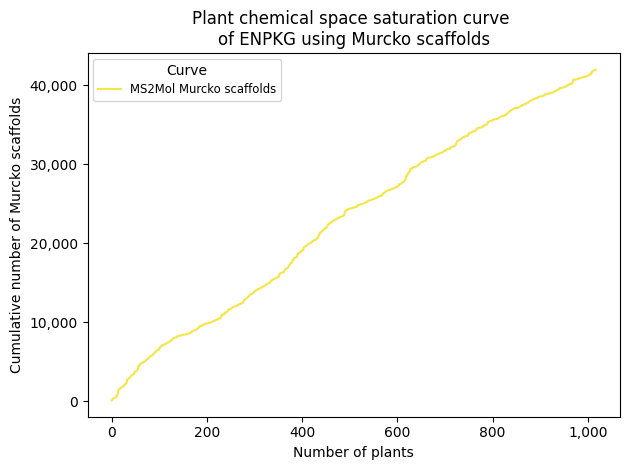

In [17]:
MURCKO_COLOR_PALETTE = [
    "#F6E547",
    "#FA5F0D",
    "#E93848",
]

for index, (curve_name, cumulative_count) in enumerate(murcko_curves_dfs_dict.items()):

    if curve_name != "murcko_ms2mol":
        continue

    curve_df = pd.DataFrame(
        [
            {"plant_count": i, "cumulative_count": c}
            for i, c in enumerate(cumulative_count)
        ]
    )

    # Make a curve with seaborn and matplotlib where the x axis is the number of plants and the y axis is the number of unique inchikeys
    sns.lineplot(
        data=curve_df,
        x="plant_count",
        y="cumulative_count",
        label=CURVE_NAMES_RENAMED[curve_name],
        color=MURCKO_COLOR_PALETTE[index],
    )

plt.gca().get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))
)

plt.gca().get_xaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))
)

plt.xlabel("Number of plants")
plt.ylabel("Cumulative number of Murcko scaffolds")
plt.legend(title="Curve", loc="upper left", fontsize="small")

plt.title("Plant chemical space saturation curve \nof ENPKG using Murcko scaffolds")
plt.tight_layout()

plt.savefig("../figures/cumulative_murcko_saturation.png", dpi=400)

plt.show()

### Make the plot of the predictions for the ENPKG dataset

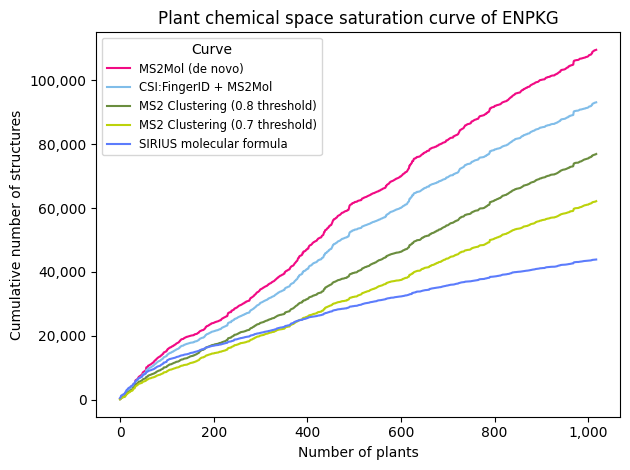

In [18]:
subset_curves_dfs_dict = {
    k: v
    for k, v in curves_dfs_dict.items()
    if k not in ["entropy_90", "entropy_60", "entropy_50"]
}

for index, (curve_name, cumulative_count) in enumerate(subset_curves_dfs_dict.items()):

    curve_df = pd.DataFrame(
        [
            {"plant_count": i, "cumulative_count": c}
            for i, c in enumerate(cumulative_count)
        ]
    )

    # Make a curve with seaborn and matplotlib where the x axis is the number of plants and the y axis is the number of unique inchikeys
    sns.lineplot(
        data=curve_df,
        x="plant_count",
        y="cumulative_count",
        label=CURVE_NAMES_RENAMED[curve_name],
        color=DEFAULT_COLOR_PALETTE[index],
    )

plt.gca().get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))
)

plt.gca().get_xaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))
)

plt.xlabel("Number of plants")
plt.ylabel("Cumulative number of structures")
plt.legend(title="Curve", loc="upper left", fontsize="small")

plt.title("Plant chemical space saturation curve of ENPKG")
plt.tight_layout()

plt.savefig("../figures/cumulative_structure_graph.png", dpi=400)

plt.show()

# Projection curves based on the predictions for the ENPKG dataset

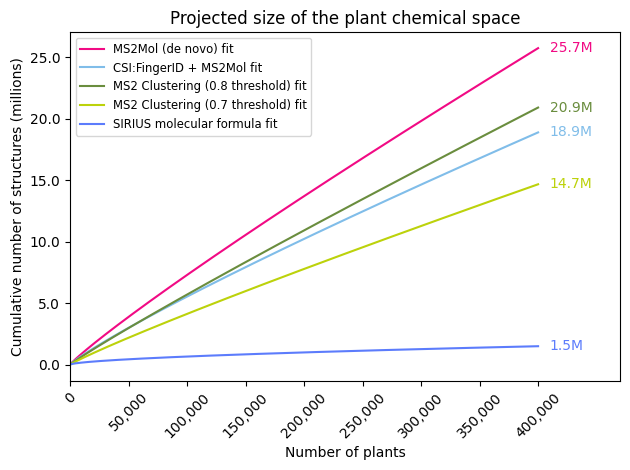

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, NullFormatter
from scipy.optimize import least_squares


# Define the y-axis formatter to display values in millions
def formatter_short(x, pos):
    return f"{x / 1e6:.1f}M"


def formatter_long(x, pos):
    return f"{x / 1e6:.1f} million"


def formatter(x, pos):
    return f"{x / 1e6:.1f}"


def power_law(x, a, b):
    return a * x**b


def residuals(params, x, y):
    return y - power_law(x, *params)


def fit_power_law(x, y):
    res = least_squares(residuals, [1, 1], args=(x, y))
    return res.x


# Plot
fig, ax = plt.subplots()

for index, (curve_name, cumulative_count) in enumerate(subset_curves_dfs_dict.items()):
    # Create DataFrame from cumulative counts
    curve_df = pd.DataFrame(
        [
            {"plant_count": i, "cumulative_count": c}
            for i, c in enumerate(cumulative_count)
        ]
    )
    x = curve_df["plant_count"]
    y = curve_df["cumulative_count"]

    # Fit power law
    a, b = fit_power_law(x, y)

    # Plot the fitted power law curve
    plt.plot(
        np.arange(400_000),
        power_law(np.arange(400_000), a, b),
        label=f"{CURVE_NAMES_RENAMED[curve_name]} fit",
        color=DEFAULT_COLOR_PALETTE[index],
    )

    estimated_size_for_400k_plants = power_law(400_000, a, b)

    # Format the number with scientific notation
    estimated_size_for_400k_plants_sci = formatter_short(
        estimated_size_for_400k_plants, 0
    )
    # Plot the estimated size for 400k plants outside the plot on the right
    plt.text(
        410_000,
        estimated_size_for_400k_plants,
        estimated_size_for_400k_plants_sci,
        ha="left",
        va="center",
        color=DEFAULT_COLOR_PALETTE[index],
    )

# Set the y-axis formatter
ax.yaxis.set_major_formatter(FuncFormatter(formatter))
ax.yaxis.set_minor_formatter(NullFormatter())

plt.gca().get_xaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))
)

plt.xlim(0, 470_000)
plt.xticks(rotation=45)

# make ticks till 400k
plt.xticks(np.arange(0, 400_001, 50_000))

plt.legend(fontsize="small")
plt.xlabel("Number of plants")
plt.ylabel("Cumulative number of structures (millions)")
plt.title("Projected size of the plant chemical space")
plt.tight_layout()

plt.savefig("../figures/projections.png", dpi=400)


plt.show()

### zoom in

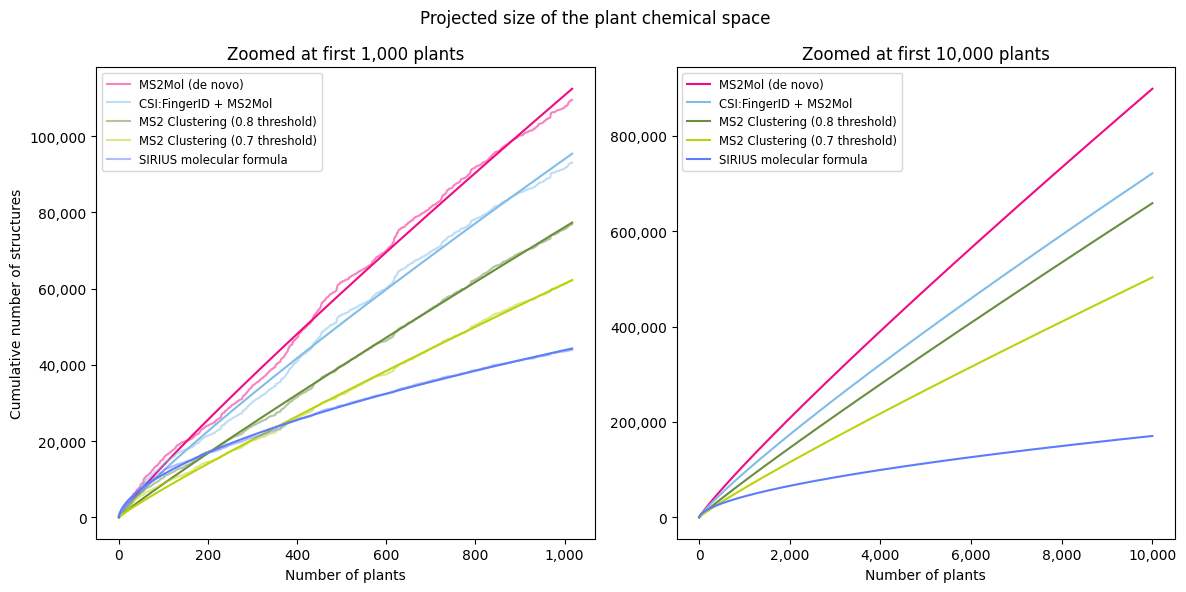

In [20]:
plt.figure(figsize=(12, 6))

for i, (curve_name, cumulative_count) in enumerate(subset_curves_dfs_dict.items()):
    curve_df = pd.DataFrame(
        [
            {"plant_count": i, "cumulative_count": c}
            for i, c in enumerate(cumulative_count)
        ]
    )
    x = curve_df["plant_count"]
    y = curve_df["cumulative_count"]
    a, b = fit_power_law(x, y)

    plt.subplot(1, 2, 1)
    plt.plot(
        x,
        y,
        label=f"{CURVE_NAMES_RENAMED[curve_name]}",
        color=DEFAULT_COLOR_PALETTE[i],
        alpha=0.5,
    )
    plt.plot(
        np.arange(len(x)),
        power_law(np.arange(len(x)), a, b),
        color=DEFAULT_COLOR_PALETTE[i],
    )
    plt.title("Zoomed at first 1,000 plants")
    plt.ylabel("Cumulative number of structures")
    plt.xlabel("Number of plants")
    plt.legend(fontsize="small")
    plt.gca().get_yaxis().set_major_formatter(
        plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))
    )

    plt.gca().get_xaxis().set_major_formatter(
        plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))
    )

    plt.subplot(1, 2, 2)
    plt.plot(
        np.arange(10000),
        power_law(np.arange(10000), a, b),
        color=DEFAULT_COLOR_PALETTE[i],
        label=f"{CURVE_NAMES_RENAMED[curve_name]}",
    )
    plt.title("Zoomed at first 10,000 plants")
    plt.xlabel("Number of plants")
    plt.legend(fontsize="small")
    plt.gca().get_yaxis().set_major_formatter(
        plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))
    )

    plt.gca().get_xaxis().set_major_formatter(
        plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))
    )

plt.suptitle("Projected size of the plant chemical space")
plt.tight_layout()

plt.savefig("../figures/projections_zoomed.png", dpi=400)

plt.show()

# Entropy thresholds

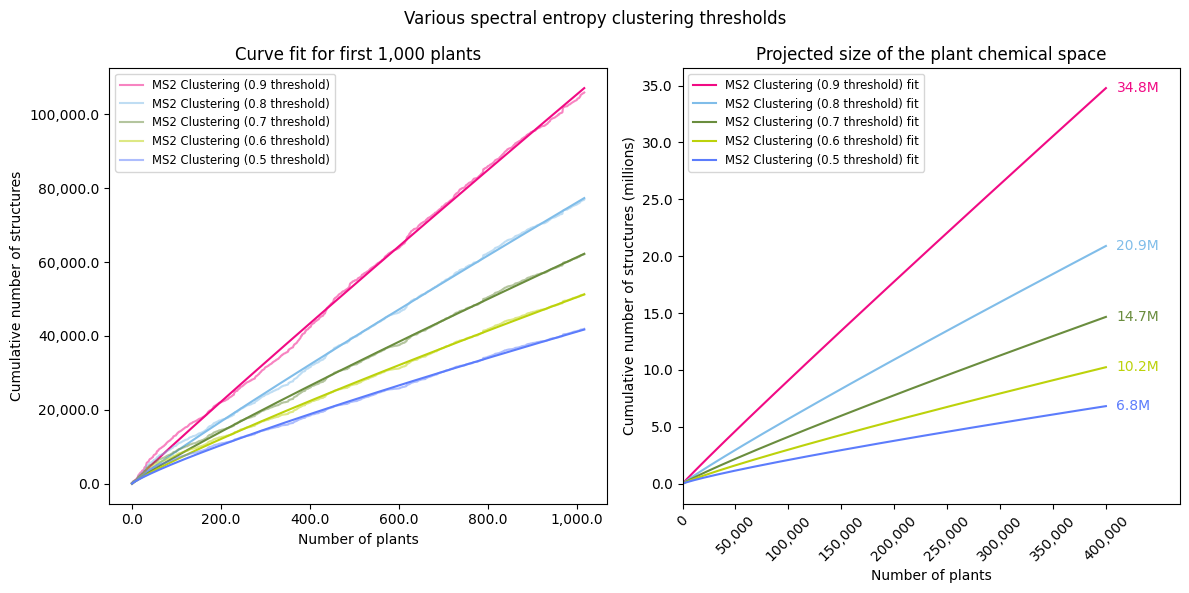

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter, NullFormatter


# Define your formatter for millions
def formatter(x, pos):
    return f"{x / 1e6:.1f}"


plt.figure(figsize=(12, 6))

entropy_curves_dfs_dict = {
    k: v for k, v in curves_dfs_dict.items() if k.startswith("entropy")
}

for i, (curve_name, cumulative_count) in enumerate(entropy_curves_dfs_dict.items()):
    curve_df = pd.DataFrame(
        [
            {"plant_count": i, "cumulative_count": c}
            for i, c in enumerate(cumulative_count)
        ]
    )
    x = curve_df["plant_count"]
    y = curve_df["cumulative_count"]
    a, b = fit_power_law(x, y)

    # Subplot 1
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(
        x,
        y,
        label=f"{CURVE_NAMES_RENAMED[curve_name]}",
        color=DEFAULT_COLOR_PALETTE[i],
        alpha=0.5,
    )
    ax1.plot(
        np.arange(len(x)),
        power_law(np.arange(len(x)), a, b),
        color=DEFAULT_COLOR_PALETTE[i],
    )
    ax1.set_title("Curve fit for first 1,000 plants")
    ax1.set_ylabel("Cumulative number of structures")
    ax1.set_xlabel("Number of plants")
    ax1.legend(fontsize="small")
    ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, loc: f"{x:,}"))
    ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, loc: f"{x:,}"))

    # Subplot 2
    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(
        np.arange(400_000),
        power_law(np.arange(400_000), a, b),
        label=f"{CURVE_NAMES_RENAMED[curve_name]} fit",
        color=DEFAULT_COLOR_PALETTE[i],
    )

    estimated_size_for_400k_plants = power_law(400_000, a, b)
    estimated_size_for_400k_plants_sci = formatter_short(
        estimated_size_for_400k_plants, 0
    )

    # Add annotation for estimated size
    ax2.text(
        410_000,
        estimated_size_for_400k_plants,
        estimated_size_for_400k_plants_sci,
        ha="left",
        va="center",
        color=DEFAULT_COLOR_PALETTE[i],
    )
    ax2.set_xlim(0, 470_000)
    ax2.set_xticks(np.arange(0, 400_001, 50_000))
    ax2.set_xticklabels(
        [f"{int(x):,}" for x in np.arange(0, 400_001, 50_000)], rotation=45
    )

    # Set y-axis formatter for millions
    ax2.yaxis.set_major_formatter(FuncFormatter(formatter))
    ax2.yaxis.set_minor_formatter(NullFormatter())

    ax2.set_xlabel("Number of plants")
    ax2.set_ylabel("Cumulative number of structures (millions)")
    ax2.set_title("Projected size of the plant chemical space")
    ax2.legend(fontsize="small")

plt.suptitle("Various spectral entropy clustering thresholds")
plt.tight_layout()

plt.savefig("../figures/spectral_entropy_thresholds.png", dpi=400)
plt.show()

### Holdout set

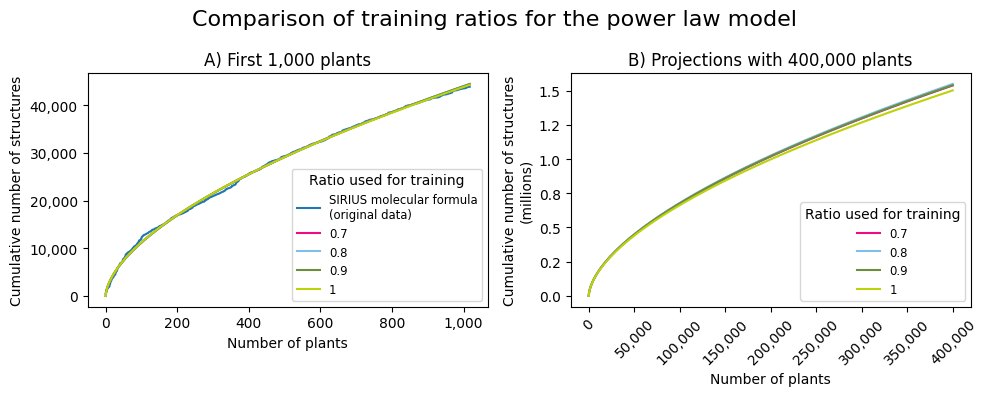

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# First plot
curve_name = "formula"
cumulative_count = curves_dfs_dict[curve_name]
curve_df = pd.DataFrame(
    [{"plant_count": i, "cumulative_count": c} for i, c in enumerate(cumulative_count)]
)

ax1.plot(
    curve_df["plant_count"],
    curve_df["cumulative_count"],
    label="SIRIUS molecular formula\n(original data)",
)

for i, train_size in enumerate([0.7, 0.8, 0.9, 1]):
    curve_df_train = curve_df.iloc[: int(len(curve_df) * train_size)]
    x = curve_df_train["plant_count"]
    y = curve_df_train["cumulative_count"]
    a, b = fit_power_law(x, y)

    ax1.plot(
        np.arange(len(curve_df)),
        power_law(np.arange(len(curve_df)), a, b),
        label=f"{train_size}",
        color=DEFAULT_COLOR_PALETTE[i],
    )

ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

ax1.legend(title="Ratio used for training", fontsize="small")
ax1.set_xlabel("Number of plants")
ax1.set_ylabel("Cumulative number of structures")

fig.suptitle("Comparison of training ratios for the power law model", fontsize=16)

ax1.set_title("A) First 1,000 plants")

# Second plot
curve_name = "formula"
cumulative_count = curves_dfs_dict[curve_name]
curve_df = pd.DataFrame(
    [{"plant_count": i, "cumulative_count": c} for i, c in enumerate(cumulative_count)]
)

for i, train_size in enumerate([0.7, 0.8, 0.9, 1]):
    curve_df_train = curve_df.iloc[: int(len(curve_df) * train_size)]
    x = curve_df_train["plant_count"]
    y = curve_df_train["cumulative_count"]
    a, b = fit_power_law(x, y)

    ax2.plot(
        np.arange(400_000),
        power_law(np.arange(400_000), a, b),
        label=f"{train_size}",
        color=DEFAULT_COLOR_PALETTE[i],
    )

ax2.yaxis.set_major_formatter(FuncFormatter(formatter))
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))


for tick in ax2.get_xticklabels():
    tick.set_rotation(45)


ax2.legend(title="Ratio used for training", fontsize="small")
ax2.set_xlabel("Number of plants")
ax2.set_ylabel("Cumulative number of structures\n(millions)")
ax2.set_title("B) Projections with 400,000 plants")

plt.tight_layout()

plt.savefig("../figures/comparing_training_ratios.png", dpi=400)

plt.show()